# Backyard Bird Classifier

## 1. Business Understanding

Project FeederWatch, operated by the Cornell Lab of Ornithology and Birds Canada, is a community science program that encourages individuals across North America to monitor and report bird species visiting their feeders. The project has been running since 1987 and provides a valuable long-term dataset to scientists studying the distribution, abundance, and migration patterns of wintering bird species.

Participants submit bird counts from their homes, nature centers, schools, or community spaces using a flexible schedule between November and April. These data have been used in numerous scientific studies, revealing trends in species ranges, population shifts, and feeder use. However, because observations are made by people of all skill levels—many of them amateur birders—identification errors are common. This introduces noise into the dataset, potentially obscuring long-term trends and biological signals.

To mitigate this limitation, this project proposes a computer vision approach to improve the consistency and accuracy of bird species identification from images. By training a machine learning model to classify feeder birds, we can provide an automated or semi-automated tool to assist human observers and validate their reports.

Cornell’s NABirds dataset contains over 48,000 annotated images of 555 bird species commonly observed in North America. This project will subset that dataset using Cornell’s list of the 100 most common feeder birds and train a deep learning model to recognize them from photographs. The long-term goal is to support systems that can automatically identify feeder birds from camera traps or assist FeederWatch participants in double-checking their own identifications.

### Objective

Build and evaluate an image classification model that can:

- Automatically identify bird species from a curated list of the 100 most common feeder birds
- Achieve greater than 80% overall classification accuracy
- Provide per-class metrics such as precision, recall, and F1-score to assess individual species performance
- Incorporate interpretability tools (e.g., LIME and Grad-CAM) to explain model predictions
- Be exportable to lightweight formats (e.g., ONNX) for deployment on edge devices like the Raspberry Pi

### Data Sources

- NABirds Dataset: [https://dl.allaboutbirds.org/nabirds](https://dl.allaboutbirds.org/nabirds)
- FeederWatch Program: [https://feederwatch.org](https://feederwatch.org)
- 100 Common Feeder Birds: [https://feederwatch.org/learn/common-feeder-birds/](https://feederwatch.org/learn/common-feeder-birds/)

## 2. Data Understanding

#### Dataset Access

This notebook uses a public subset of the NABirds dataset hosted on Kaggle:

**Dataset:** [Backyard Feeder Birds (NABirds Subset)](https://www.kaggle.com/datasets/jakemccaig/backyard-feeder-birds-nabirds-subset)  
**Owner:** [jakemccaig](https://www.kaggle.com/jakemccaig)  
**Structure:** ImageNet-style `train/`, `val/`, and `class_labels.txt`

---

This dataset is a subset of the NABirds dataset filtered to include the 100 most common backyard feeder birds in North America, based on recommendations from the Cornell Lab of Ornithology. It follows an ImageNet-style structure with a `train/` and `val/` folder and a `class_labels.txt` file.

Each subfolder within `train/` and `val/` corresponds to a species label, which may include additional descriptors (e.g., age, sex, plumage). These distinctions enable more detailed recognition, as many feeder birds differ in appearance by season or gender.

---

### Dataset Composition Summary

- Total classes: **134**
- Total training images: **10,562**
- Total validation images: **2,690**
- Total images overall: **13,252**
- Maximum images in a single class: **120**
- Minimum images in a single class: **13**
- Median images per class: **110**
- Mean images per class: **98.90**

The dataset is reasonably balanced, with most classes having over 75 total images. Manual curation helped reduce severe class imbalance, but we will still monitor for underrepresented species during training.

---

### Class Distribution Visualizations

A full bar chart and heatmap visualization confirm that the number of images per species is relatively consistent across both training and validation splits.

---

### Image Sample Inspection

A random set of images were sampled and show birds at various distances, angles, and with various backgrounds, exposures, brightness, and contrasts.

---

### Image Size & Aspect Ratio Summary

- Total images analyzed: **10,562**
- Image widths range from **90 px** to **1024 px**, with a mean of **906.4 px**
- Image heights range from **100 px** to **1024 px**, with a mean of **730.7 px**
- Aspect ratios (width ÷ height) range from **0.45** to **2.39**, with a mean of **1.28**

These statistics indicate that most images are roughly landscape or square in shape, though a small number of outliers exist. Images will be resized to 600×600 during preprocessing to ensure model consistency.

In [28]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageFile, UnidentifiedImageError
import random
import numpy as np
import tqdm
import re
import pickle
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms, models, datasets
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import kagglehub
import os
import pickle
from PIL import Image
import numpy as np
from tqdm import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.utils.class_weight import compute_class_weight
from torchvision.models import efficientnet_b7, EfficientNet_B7_Weights
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch
import copy
import json
import glob
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm

In [2]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 110.0 MB/s eta 0:00:00


In [3]:
# Download latest version
path = kagglehub.dataset_download("jakemccaig/backyard-feeder-birds-nabirds-subset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/backyard-feeder-birds-nabirds-subset


In [4]:
# Run this cell if loading data from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Define dataset paths
dataset_root = "/root/.cache/kagglehub/datasets/jakemccaig/backyard-feeder-birds-nabirds-subset/versions/1"
train_path = os.path.join(dataset_root, "train")
val_path = os.path.join(dataset_root, "val")

# Define and create cache path
cache_path = os.path.join(dataset_root, "cache")
os.makedirs(cache_path, exist_ok=True)

# Load class folder names
class_names = sorted(os.listdir(train_path))

Dataset Composition Summary:
- Total classes: 134
- Total training images: 10562
- Total validation images: 2690
- Total images overall: 13252
- Max images in a single class: 120
- Min images in a single class: 13
- Median images per class: 110.0
- Mean images per class: 98.90


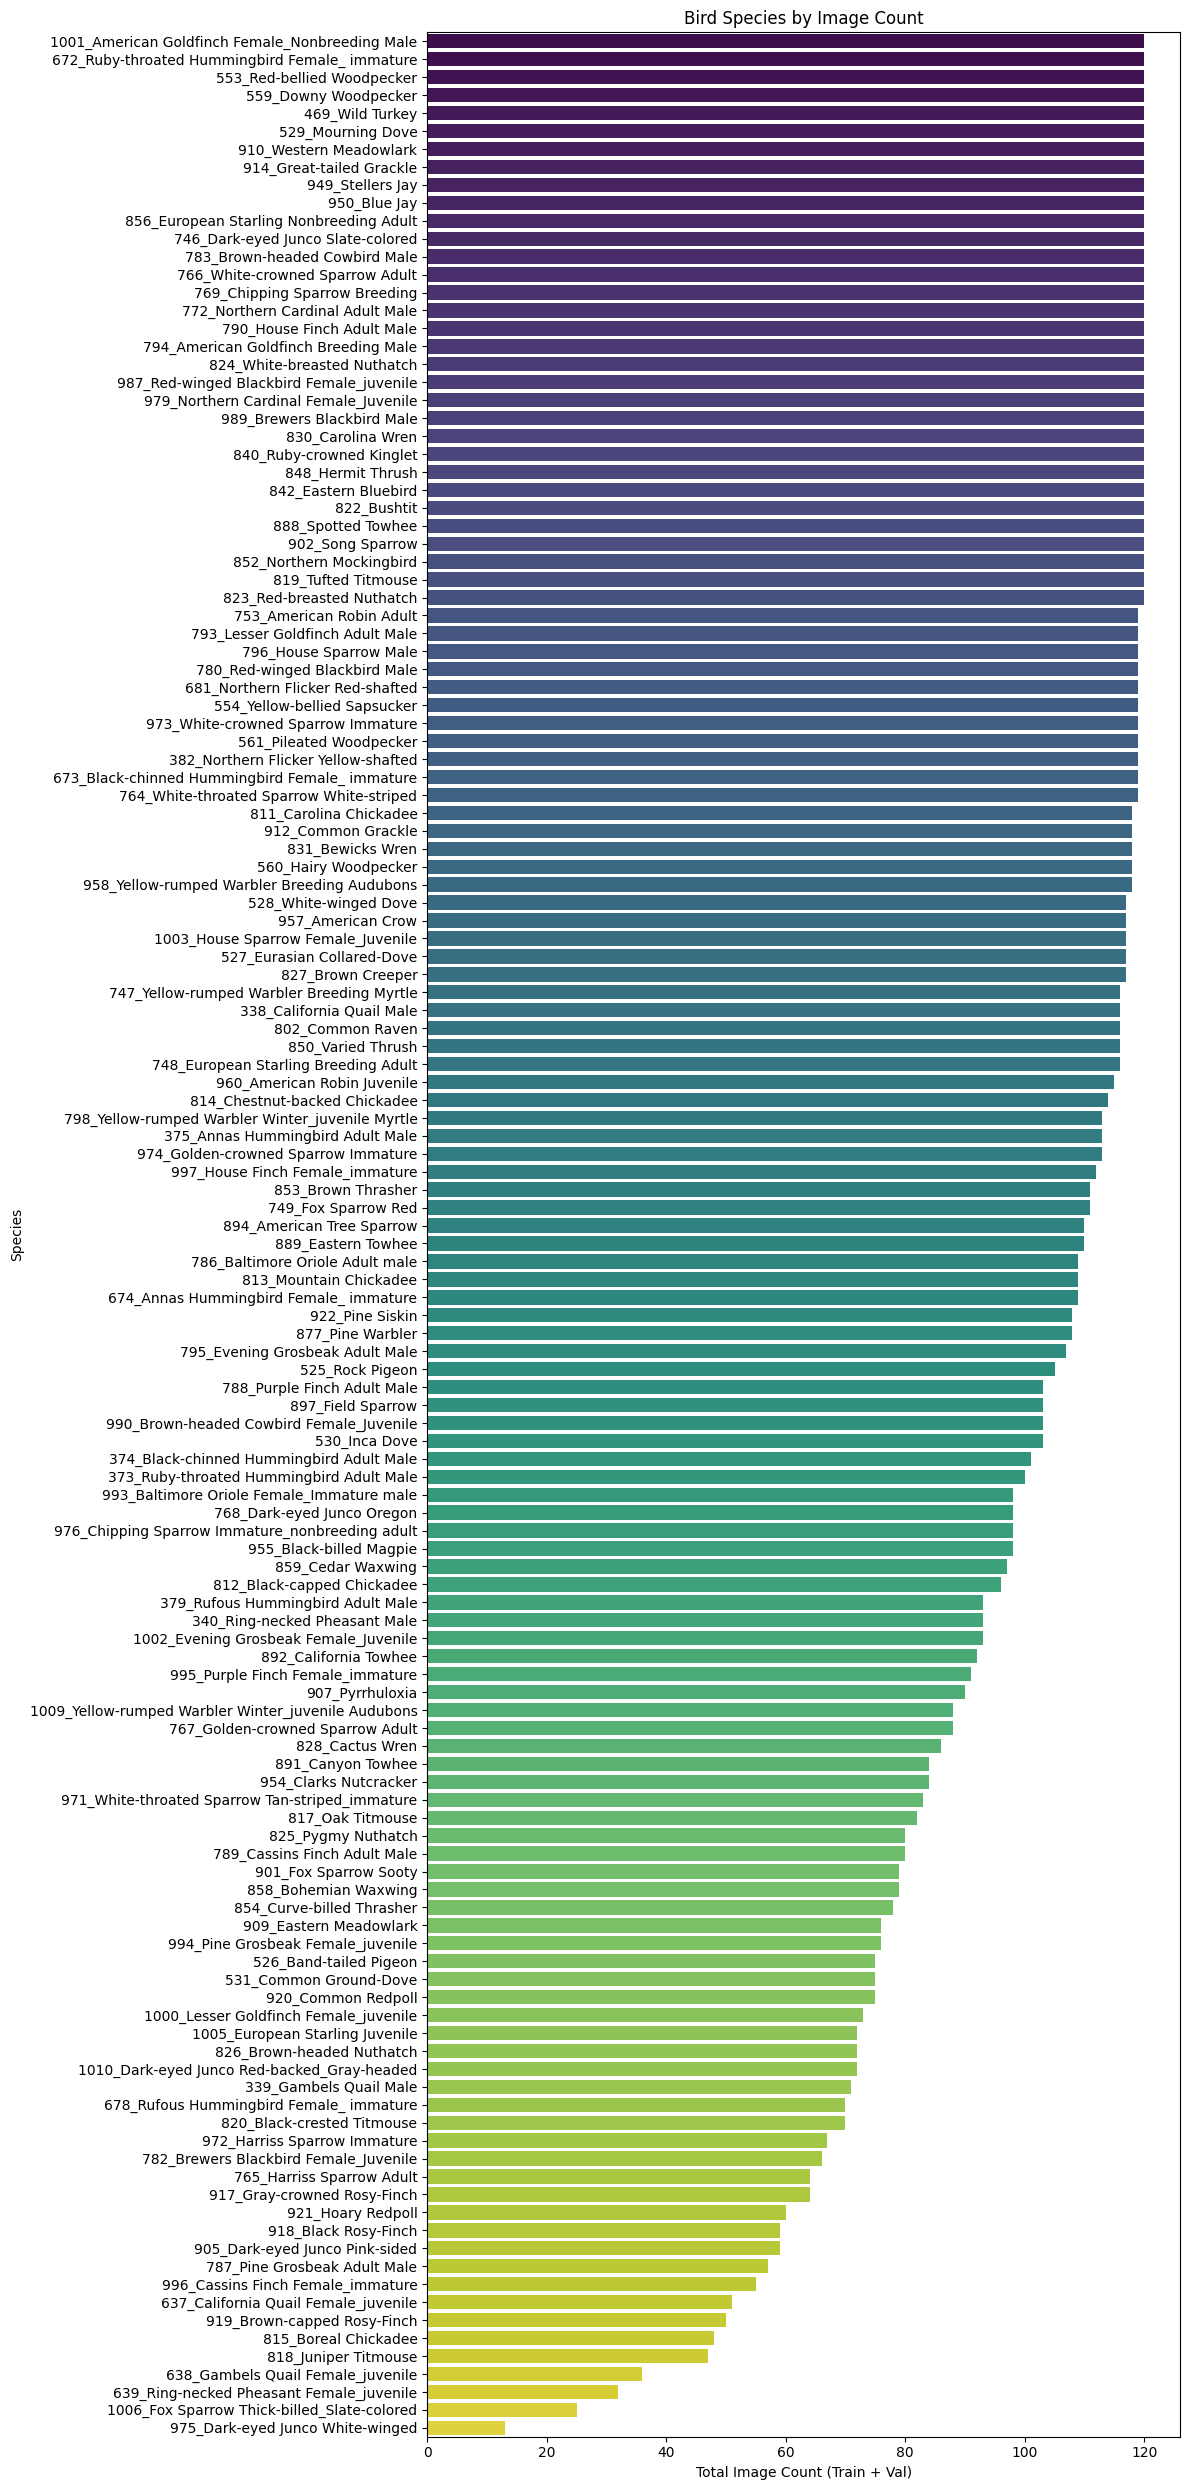

In [6]:
# Visualize image counts per class
class_names = sorted([
    d for d in os.listdir(train_path)
    if os.path.isdir(os.path.join(train_path, d))
])

# Count images per class
train_counts = {cls: len(os.listdir(os.path.join(train_path, cls))) for cls in class_names}
val_counts = {cls: len(os.listdir(os.path.join(val_path, cls))) for cls in class_names}

# Combine into DataFrame
df_counts = pd.DataFrame({
    "Class": class_names,
    "Train Count": [train_counts[cls] for cls in class_names],
    "Val Count": [val_counts[cls] for cls in class_names]
})
df_counts["Total"] = df_counts["Train Count"] + df_counts["Val Count"]
df_counts = df_counts.sort_values("Total", ascending=False)

# Summary output
print("Dataset Composition Summary:")
print(f"- Total classes: {len(class_names)}")
print(f"- Total training images: {sum(df_counts['Train Count'])}")
print(f"- Total validation images: {sum(df_counts['Val Count'])}")
print(f"- Total images overall: {sum(df_counts['Total'])}")
print(f"- Max images in a single class: {df_counts['Total'].max()}")
print(f"- Min images in a single class: {df_counts['Total'].min()}")
print(f"- Median images per class: {df_counts['Total'].median()}")
print(f"- Mean images per class: {df_counts['Total'].mean():.2f}")

# Plot top 134 (all)
plt.figure(figsize=(12, 25))
sns.barplot(
    data=df_counts.head(134),
    x="Total", y="Class", hue="Class", palette="viridis", legend=False
)
plt.title("Bird Species by Image Count")
plt.xlabel("Total Image Count (Train + Val)")
plt.ylabel("Species")
plt.tight_layout()
plt.show()

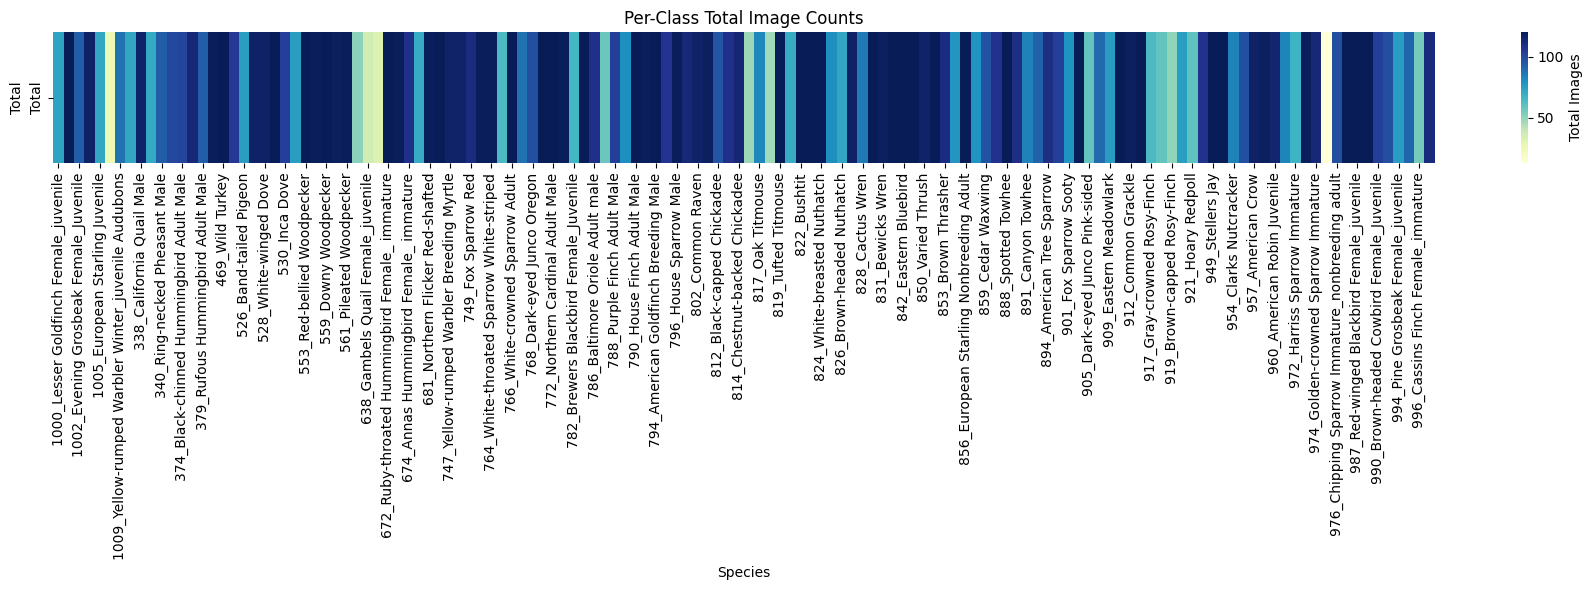

In [7]:
# Sort by class name for consistent layout
df_heatmap_total = df_counts.sort_values("Class").set_index("Class")[["Total"]]

# Transpose for a horizontal layout
plt.figure(figsize=(18, 6))
sns.heatmap(df_heatmap_total.T, cmap="YlGnBu", cbar_kws={'label': 'Total Images'})
plt.title("Per-Class Total Image Counts")
plt.xlabel("Species")
plt.ylabel("Total")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

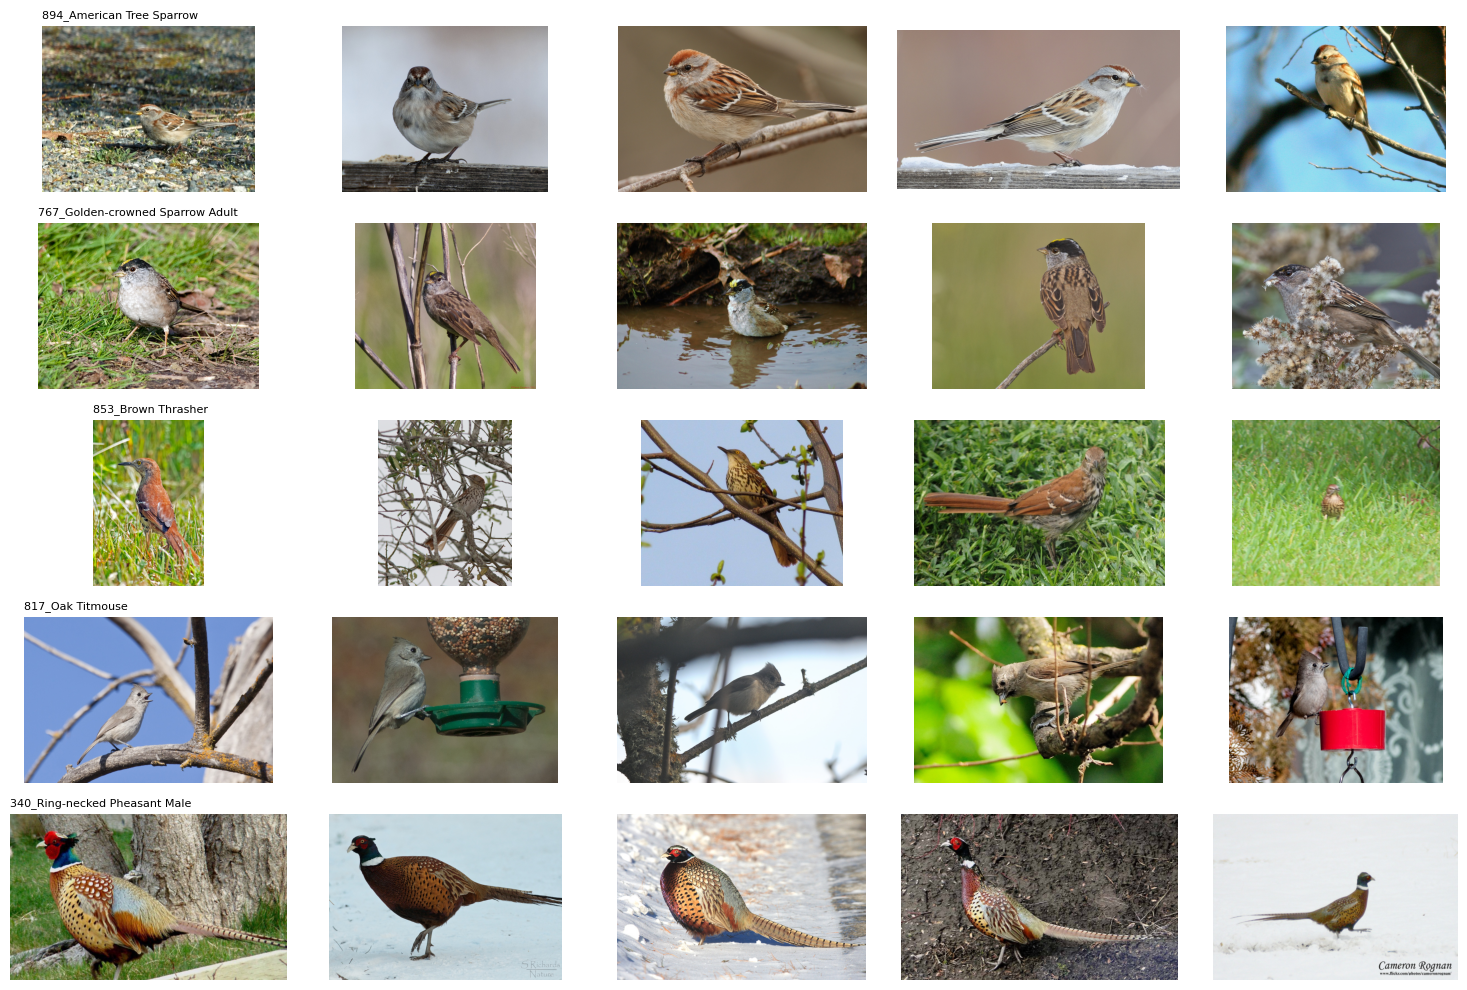

In [8]:
# View a sampling of images
num_classes_to_sample = 5
images_per_class = 5

sampled_classes = random.sample(class_names, num_classes_to_sample)

fig, axes = plt.subplots(num_classes_to_sample, images_per_class, figsize=(15, 10))
for row_idx, cls in enumerate(sampled_classes):
    img_files = os.listdir(os.path.join(train_path, cls))
    img_samples = random.sample(img_files, min(images_per_class, len(img_files)))
    for col_idx, img_file in enumerate(img_samples):
        img_path = os.path.join(train_path, cls, img_file)
        img = Image.open(img_path).convert("RGB")
        axes[row_idx, col_idx].imshow(img)
        axes[row_idx, col_idx].axis("off")
        if col_idx == 0:
            axes[row_idx, col_idx].set_title(cls[:40], fontsize=8, loc="left")
plt.tight_layout()
plt.show()

Image Resolution Statistics (Train Set):
- Total images analyzed: 10562
- Widths: min=90 px | max=1024 px | mean=906.4 px
- Heights: min=100 px | max=1024 px | mean=730.7 px
- Aspect Ratio (W/H): min=0.45 | max=2.39 | mean=1.28


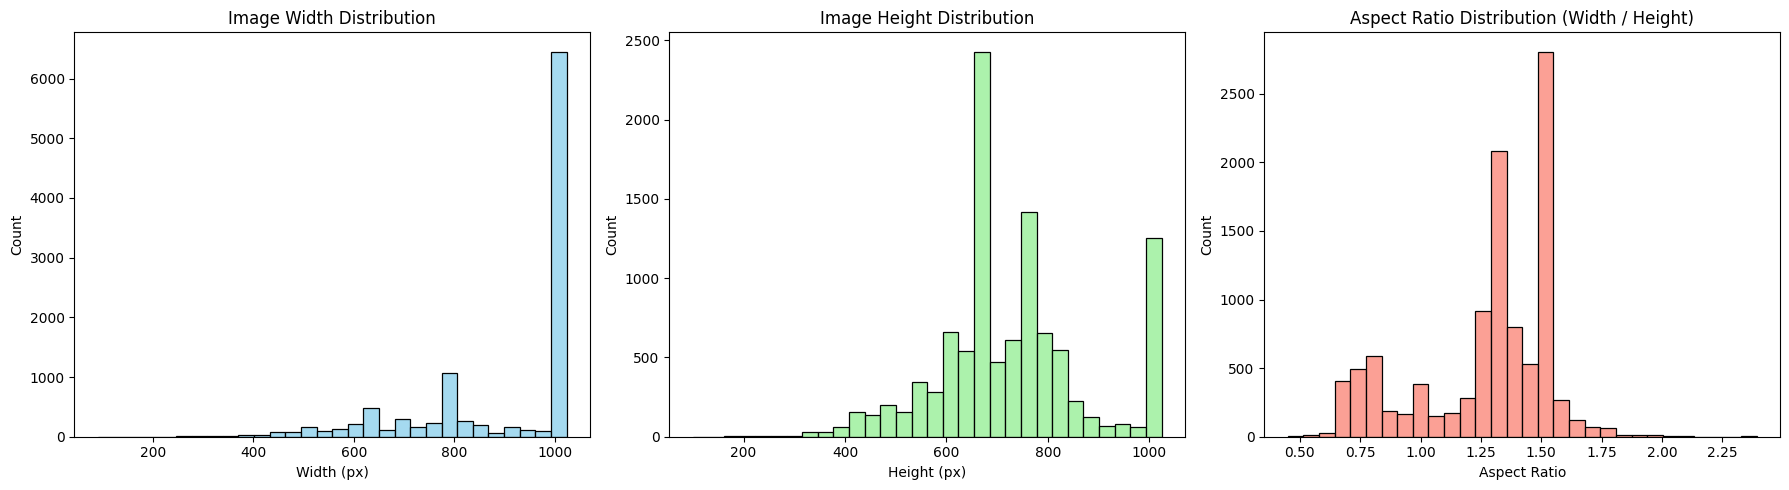

In [9]:
# Visualize image sizes and aspect ratios

# Collect image dimensions
widths, heights, aspect_ratios = [], [], []

for cls in os.listdir(train_path):
    class_dir = os.path.join(train_path, cls)
    if not os.path.isdir(class_dir): continue
    for fname in os.listdir(class_dir):
        fpath = os.path.join(class_dir, fname)
        try:
            with Image.open(fpath) as img:
                w, h = img.size
                widths.append(w)
                heights.append(h)
                aspect_ratios.append(w / h)
        except:
            continue  # skip unreadable images

# Print summary stats
print("Image Resolution Statistics (Train Set):")
print(f"- Total images analyzed: {len(widths)}")
print(f"- Widths: min={np.min(widths)} px | max={np.max(widths)} px | mean={np.mean(widths):.1f} px")
print(f"- Heights: min={np.min(heights)} px | max={np.max(heights)} px | mean={np.mean(heights):.1f} px")
print(f"- Aspect Ratio (W/H): min={np.min(aspect_ratios):.2f} | max={np.max(aspect_ratios):.2f} | mean={np.mean(aspect_ratios):.2f}")

# Plot histograms
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(widths, bins=30, ax=axes[0], color="skyblue")
axes[0].set_title("Image Width Distribution")
axes[0].set_xlabel("Width (px)")

sns.histplot(heights, bins=30, ax=axes[1], color="lightgreen")
axes[1].set_title("Image Height Distribution")
axes[1].set_xlabel("Height (px)")

sns.histplot(aspect_ratios, bins=30, ax=axes[2], color="salmon")
axes[2].set_title("Aspect Ratio Distribution (Width / Height)")
axes[2].set_xlabel("Aspect Ratio")

plt.tight_layout()
plt.show()

## 3. Data Preparation & Cleaning

Before training, I conducted a comprehensive series of cleaning and validation steps to ensure the dataset is well-structured, consistent, and free from errors. These steps are critical to prevent downstream issues during model training and evaluation.

### Image Verification

- All images in both `train/` and `val/` were scanned for corruption.
- No unreadable or invalid images were found.
- Hidden system files (e.g., `.DS_Store`) were identified and ignored during file processing.

### Class Folder Alignment

- All 134 class folders are present in both training and validation directories.
- No class mismatches or missing folders were found between splits.

### Label Sanitization

- Folder names containing commas (e.g., "Female, immature") were renamed with underscores (e.g., "Female_immature") to ensure filesystem compatibility and simplify parsing.
- Any leading or trailing whitespace in class names was stripped.
- A cleaned label file (`cleaned_class_labels.txt`) was generated from the updated `train/` directory and saved to the root of the project.

In [10]:
# Checking for any corrupted images

def check_corrupted_images(path):
    corrupted = []
    for cls in os.listdir(path):
        cls_dir = os.path.join(path, cls)
        if not os.path.isdir(cls_dir): continue
        for fname in os.listdir(cls_dir):
            fpath = os.path.join(cls_dir, fname)
            try:
                with Image.open(fpath) as img:
                    img.verify()  # Check file integrity
            except (UnidentifiedImageError, OSError):
                corrupted.append(fpath)
    return corrupted

corrupted_train = check_corrupted_images(train_path)
corrupted_val = check_corrupted_images(val_path)

print(f"Corrupted training images: {len(corrupted_train)}")
print(f"Corrupted validation images: {len(corrupted_val)}")

Corrupted training images: 0
Corrupted validation images: 0


In [11]:
# Checking training and validation alignment

train_classes = set(os.listdir(train_path))
val_classes = set(os.listdir(val_path))

only_in_train = sorted(train_classes - val_classes)
only_in_val = sorted(val_classes - train_classes)

print(f"Classes only in train (not in val): {only_in_train}")
print(f"Classes only in val (not in train): {only_in_val}")

Classes only in train (not in val): []
Classes only in val (not in train): []


In [12]:
# Checking label formatting for issues

def label_format_audit(classes):
    too_long = [c for c in classes if len(c) > 50]
    contains_commas = [c for c in classes if "," in c]
    suspicious_patterns = [c for c in classes if re.search(r'\s{2,}|[^a-zA-Z0-9 _,-]', c)]

    print(f"Classes with very long names (>50 chars): {too_long}")
    print(f"Classes containing commas: {contains_commas}")
    print(f"Classes with strange formatting or characters: {suspicious_patterns}")

label_format_audit(sorted(train_classes.union(val_classes)))

Classes with very long names (>50 chars): ['1009_Yellow-rumped Warbler Winter_juvenile Audubons']
Classes containing commas: []
Classes with strange formatting or characters: []


In [13]:
# Renaming our folders to a safer format

def rename_folders_to_safe_names(base_path):
    for folder in os.listdir(base_path):
        full_path = os.path.join(base_path, folder)

        # Skip anything that's not a directory
        if not os.path.isdir(full_path):
            continue

        # Sanitize commas
        new_name = folder.replace(",", "_").strip()

        if new_name != folder:
            new_path = os.path.join(base_path, new_name)
            print(f"Renaming: {folder} → {new_name}")
            os.rename(full_path, new_path)

# Apply to both train and val
rename_folders_to_safe_names(train_path)
rename_folders_to_safe_names(val_path)

In [14]:
# Since we updating folder names we should clean the class_labels.txt

output_path = "./cleaned_class_labels.txt"

def rename_folders_to_safe_names(base_path):
    for folder in os.listdir(base_path):
        full_path = os.path.join(base_path, folder)

        if not os.path.isdir(full_path):
            continue

        # Replace commas with underscores and strip trailing spaces
        new_name = folder.replace(",", "_").strip()

        if new_name != folder:
            new_path = os.path.join(base_path, new_name)
            print(f"Renaming: {folder} → {new_name}")
            os.rename(full_path, new_path)

# Apply to both train and val directories
rename_folders_to_safe_names(train_path)
rename_folders_to_safe_names(val_path)

# Generate cleaned class label list from train directory
cleaned_class_names = sorted([
    d for d in os.listdir(train_path)
    if os.path.isdir(os.path.join(train_path, d))
])

# Write to root-level cleaned_class_labels.txt
with open(output_path, "w") as f:
    for name in cleaned_class_names:
        f.write(name + "\n")

print(f"Saved cleaned class labels to: {output_path}")

Saved cleaned class labels to: ./cleaned_class_labels.txt


### Modeling

In [15]:
# I will create a validation class

class VerifiedImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None, cache_file=None):
        super().__init__(root, transform=transform)
        self.cache_file = cache_file
        if cache_file and os.path.exists(cache_file):
            with open(cache_file, "rb") as f:
                self.samples = pickle.load(f)
        else:
            valid_samples = []
            for path, class_idx in self.samples:
                if os.path.basename(path).startswith("._"):
                    continue
                try:
                    with Image.open(path) as img:
                        img.convert("RGB")
                    valid_samples.append((path, class_idx))
                except:
                    continue
            self.samples = valid_samples
            if cache_file:
                with open(cache_file, "wb") as f:
                    pickle.dump(self.samples, f)

In [16]:
# I'll start with a baseline CNN from scratch

# Custom CNN input size
input_size = 224
BATCH_SIZE = 256

# Transforms (light augmentations for baseline CNN)
train_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
])

# Load datasets
train_dataset = VerifiedImageFolder(
    train_path, transform=train_transforms,
    cache_file=os.path.join(cache_path, "train_cache.pkl")
)

val_dataset = VerifiedImageFolder(
    val_path, transform=val_transforms,
    cache_file=os.path.join(cache_path, "val_cache.pkl")
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

NUM_CLASSES = len(train_dataset.classes)

In [17]:
# Setting device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Building the model

class BirdCNN(nn.Module):
    def __init__(self, num_classes):
        super(BirdCNN, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # (224x224) → (112x112)
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # (112x112) → (56x56)
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # (56x56) → (28x28)
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # (28x28) → (14x14)
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.classifier(x)
        return x

model = BirdCNN(num_classes=NUM_CLASSES).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [18]:
print("CUDA available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")
print(next(model.parameters()).device)


CUDA available: True
Device name: NVIDIA A100-SXM4-40GB
cuda:0


In [19]:
import time

model.train()
start_time = time.time()

for i, (inputs, labels) in enumerate(train_loader):
    print(f"Batch {i}: {inputs.shape}")
    if i == 1:
        break

print(f"Loader ran in {time.time() - start_time:.2f} seconds")


Batch 0: torch.Size([256, 3, 224, 224])
Batch 1: torch.Size([256, 3, 224, 224])
Loader ran in 5.74 seconds



Epoch 1/10


<ipython-input-20-531b48927ce2>:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-20-531b48927ce2>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 4.8863 | Acc: 0.0073
Val   Loss: 4.8473 | Acc: 0.0126
Epoch duration: 44.85 seconds

Epoch 2/10
Train Loss: 4.7716 | Acc: 0.0172
Val   Loss: 4.6605 | Acc: 0.0279
Epoch duration: 44.45 seconds

Epoch 3/10
Train Loss: 4.6241 | Acc: 0.0256
Val   Loss: 4.5672 | Acc: 0.0372
Epoch duration: 45.00 seconds

Epoch 4/10
Train Loss: 4.5111 | Acc: 0.0373
Val   Loss: 4.4490 | Acc: 0.0480
Epoch duration: 45.29 seconds

Epoch 5/10
Train Loss: 4.3470 | Acc: 0.0629
Val   Loss: 4.2974 | Acc: 0.0699
Epoch duration: 46.09 seconds

Epoch 6/10
Train Loss: 4.1984 | Acc: 0.0800
Val   Loss: 4.1617 | Acc: 0.0840
Epoch duration: 45.13 seconds

Epoch 7/10
Train Loss: 4.0233 | Acc: 0.1054
Val   Loss: 4.0442 | Acc: 0.1015
Epoch duration: 45.02 seconds

Epoch 8/10
Train Loss: 3.8428 | Acc: 0.1285
Val   Loss: 3.9765 | Acc: 0.1126
Epoch duration: 45.05 seconds

Epoch 9/10
Train Loss: 3.6488 | Acc: 0.1575
Val   Loss: 3.8571 | Acc: 0.1323
Epoch duration: 44.79 seconds

Epoch 10/10
Train Loss: 3.4407 | Acc: 0

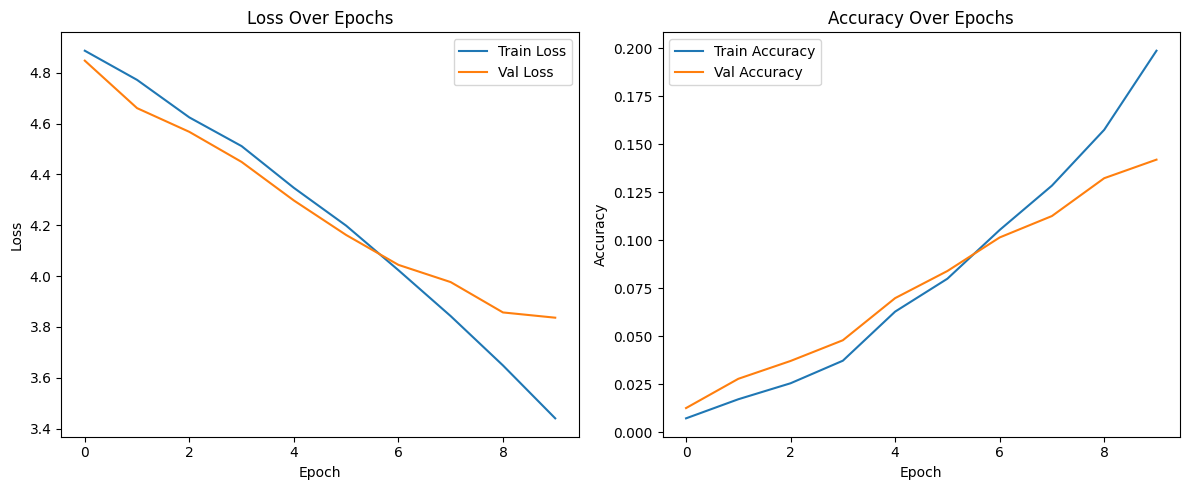


Classification Report (Validation Set):
                                                     precision    recall  f1-score   support

              1000_Lesser Goldfinch Female_juvenile      0.000     0.000     0.000        15
    1001_American Goldfinch Female_Nonbreeding Male      0.250     0.042     0.071        24
              1002_Evening Grosbeak Female_Juvenile      0.087     0.105     0.095        19
                 1003_House Sparrow Female_Juvenile      0.000     0.000     0.000        24
                    1005_European Starling Juvenile      0.200     0.067     0.100        15
        1006_Fox Sparrow Thick-billed_Slate-colored      0.000     0.000     0.000         5
1009_Yellow-rumped Warbler Winter_juvenile Audubons      0.000     0.000     0.000        18
        1010_Dark-eyed Junco Red-backed_Gray-headed      1.000     0.067     0.125        15
                          338_California Quail Male      0.279     0.500     0.358        24
                            

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [20]:
import time
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from torch.cuda.amp import autocast, GradScaler

# Enable cudnn autotuner for faster convs
torch.backends.cudnn.benchmark = True

EPOCHS = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_acc = 0.0
best_model_wts = None

scaler = GradScaler()

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    start_time = time.time()

    model.train()
    running_loss, correct = 0.0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()

    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc = correct / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    # Validation phase
    model.eval()
    val_loss, val_correct = 0.0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_correct += (outputs.argmax(1) == labels).sum().item()
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_val_acc = val_correct / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    print(f"Train Loss: {epoch_train_loss:.4f} | Acc: {epoch_train_acc:.4f}")
    print(f"Val   Loss: {epoch_val_loss:.4f} | Acc: {epoch_val_acc:.4f}")
    print(f"Epoch duration: {time.time() - start_time:.2f} seconds")

    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        best_model_wts = model.state_dict()

# Load best model weights
model.load_state_dict(best_model_wts)

# Plot training curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Final classification report
print("\nClassification Report (Validation Set):")
print(classification_report(all_labels, all_preds, target_names=val_dataset.classes, digits=3))

overall_acc = accuracy_score(all_labels, all_preds)
print(f"\nOverall Validation Accuracy: {overall_acc:.4f}")


In [21]:
# Set up Google Drive to save checkpoints, logs, models, etc.

# Path to your Google Drive directory
BASE_DRIVE_DIR = "/content/drive/MyDrive/birdwatcher/model_training"

# Subdirectories for checkpoints, exports, and logs
CHECKPOINT_DIR = os.path.join(BASE_DRIVE_DIR, "checkpoints")
EXPORT_DIR = os.path.join(BASE_DRIVE_DIR, "export")
LOG_PATH = os.path.join(BASE_DRIVE_DIR, "training_log.json")

# Make sure directories exist
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(EXPORT_DIR, exist_ok=True)


In [22]:
input_size = 600
BATCH_SIZE = 16

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

class VerifiedImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None, cache_file=None):
        super().__init__(root, transform=transform)
        self.cache_file = cache_file

        if cache_file and os.path.exists(cache_file):
            print(f"[INFO] Loading verified samples from cache: {cache_file}")
            with open(cache_file, "rb") as f:
                self.samples = pickle.load(f)
        else:
            print(f"[INFO] Verifying images in: {root}")
            valid_samples = []
            for path, class_idx in tqdm(self.samples, desc="Verifying"):
                if os.path.basename(path).startswith("._"):
                    continue
                try:
                    with Image.open(path) as img:
                        img.convert("RGB")
                    valid_samples.append((path, class_idx))
                except:
                    print(f"[SKIP] Invalid image: {path}")
            self.samples = valid_samples
            if cache_file:
                with open(cache_file, "wb") as f:
                    pickle.dump(self.samples, f)
                print(f"[INFO] Cached {len(valid_samples)} samples to: {cache_file}")

In [24]:
# Use verified image loader with caching
train_dataset = VerifiedImageFolder(
    train_path, transform=train_transforms,
    cache_file=os.path.join(cache_path, "train_cache.pkl")
)

val_dataset = VerifiedImageFolder(
    val_path, transform=val_transforms,
    cache_file=os.path.join(cache_path, "val_cache.pkl")
)

# Compute weights for sampler only (not for loss)
labels = [s[1] for s in train_dataset.samples]
class_weights_np = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
weights = [class_weights_np[l] for l in labels]
sampler = WeightedRandomSampler(weights, len(weights))

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Number of classes
NUM_CLASSES = len(train_dataset.classes)


[INFO] Loading verified samples from cache: /root/.cache/kagglehub/datasets/jakemccaig/backyard-feeder-birds-nabirds-subset/versions/1/cache/train_cache.pkl
[INFO] Loading verified samples from cache: /root/.cache/kagglehub/datasets/jakemccaig/backyard-feeder-birds-nabirds-subset/versions/1/cache/val_cache.pkl


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load EfficientNet-B7 with pretrained ImageNet weights
weights = EfficientNet_B7_Weights.DEFAULT
model = efficientnet_b7(weights=weights)

# Replace the classifier layer to match your number of classes
model.classifier[1] = nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
model = model.to(device)

# Loss function with class weights to address imbalance
# criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = nn.CrossEntropyLoss() # Trying without class weights
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=3, factor=0.5)


In [26]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model_wts = None

    def __call__(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.best_model_wts = copy.deepcopy(model.state_dict())
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

early_stopping = EarlyStopping()

start_epoch = 0
training_history = []

checkpoint_files = sorted(glob.glob(os.path.join(CHECKPOINT_DIR, "epoch_*.pth")), reverse=True)
if checkpoint_files:
    latest_ckpt = checkpoint_files[0]
    start_epoch = int(os.path.basename(latest_ckpt).split("_")[1].split(".")[0])
    model.load_state_dict(torch.load(latest_ckpt))
    print(f"[INFO] Resumed from {latest_ckpt}, starting at epoch {start_epoch + 1}")

    if os.path.exists(LOG_PATH):
        with open(LOG_PATH, "r") as f:
            training_history = json.load(f)


In [29]:
scaler = GradScaler()
EPOCHS = 50  # Set as needed

for epoch in range(start_epoch, EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    model.train()
    running_loss, correct = 0.0, 0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_correct += (outputs.argmax(1) == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = val_correct / len(val_loader.dataset)

    print(f"Train Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    scheduler.step(val_loss)
    early_stopping(val_loss, model)

    # Save checkpoint
    ckpt_path = os.path.join(CHECKPOINT_DIR, f"epoch_{epoch + 1}.pth")
    torch.save(model.state_dict(), ckpt_path)

    # Update history log
    training_history.append({
        "epoch": epoch + 1,
        "train_loss": epoch_loss,
        "train_acc": epoch_acc,
        "val_loss": val_loss,
        "val_acc": val_acc
    })

    with open(LOG_PATH, "w") as f:
        json.dump(training_history, f, indent=2)

    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break


<ipython-input-29-abd8a69df291>:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



Epoch 1/50


  0%|          | 0/661 [00:00<?, ?it/s]<ipython-input-29-abd8a69df291>:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 661/661 [04:22<00:00,  2.52it/s]


Train Loss: 3.2463 | Acc: 0.3217
Val   Loss: 1.3191 | Acc: 0.6327

Epoch 2/50


100%|██████████| 661/661 [04:08<00:00,  2.66it/s]


Train Loss: 1.4711 | Acc: 0.6409
Val   Loss: 0.6251 | Acc: 0.8208

Epoch 3/50


100%|██████████| 661/661 [04:08<00:00,  2.66it/s]


Train Loss: 1.0819 | Acc: 0.7257
Val   Loss: 0.4392 | Acc: 0.8602

Epoch 4/50


100%|██████████| 661/661 [04:08<00:00,  2.66it/s]


Train Loss: 0.9113 | Acc: 0.7693
Val   Loss: 0.4230 | Acc: 0.8669

Epoch 5/50


100%|██████████| 661/661 [04:08<00:00,  2.66it/s]


Train Loss: 0.8135 | Acc: 0.7934
Val   Loss: 0.3591 | Acc: 0.8840

Epoch 6/50


100%|██████████| 661/661 [04:08<00:00,  2.66it/s]


Train Loss: 0.7631 | Acc: 0.8073
Val   Loss: 0.3804 | Acc: 0.8818

Epoch 7/50


100%|██████████| 661/661 [04:08<00:00,  2.65it/s]


Train Loss: 0.6996 | Acc: 0.8213
Val   Loss: 0.3763 | Acc: 0.8874

Epoch 8/50


100%|██████████| 661/661 [04:08<00:00,  2.66it/s]


Train Loss: 0.6588 | Acc: 0.8320
Val   Loss: 0.3823 | Acc: 0.8784

Epoch 9/50


100%|██████████| 661/661 [04:09<00:00,  2.65it/s]


Train Loss: 0.6211 | Acc: 0.8416
Val   Loss: 0.3321 | Acc: 0.9007

Epoch 10/50


100%|██████████| 661/661 [04:08<00:00,  2.66it/s]


Train Loss: 0.6101 | Acc: 0.8450
Val   Loss: 0.3376 | Acc: 0.9000

Epoch 11/50


100%|██████████| 661/661 [04:08<00:00,  2.66it/s]


Train Loss: 0.5883 | Acc: 0.8486
Val   Loss: 0.3679 | Acc: 0.9000

Epoch 12/50


100%|██████████| 661/661 [04:08<00:00,  2.66it/s]


Train Loss: 0.5820 | Acc: 0.8575
Val   Loss: 0.3554 | Acc: 0.9015

Epoch 13/50


100%|██████████| 661/661 [04:09<00:00,  2.65it/s]


Train Loss: 0.5394 | Acc: 0.8653
Val   Loss: 0.3523 | Acc: 0.8967

Epoch 14/50


100%|██████████| 661/661 [04:09<00:00,  2.65it/s]


Train Loss: 0.5012 | Acc: 0.8759
Val   Loss: 0.3143 | Acc: 0.9138

Epoch 15/50


100%|██████████| 661/661 [04:08<00:00,  2.66it/s]


Train Loss: 0.4693 | Acc: 0.8858
Val   Loss: 0.2956 | Acc: 0.9186

Epoch 16/50


100%|██████████| 661/661 [04:09<00:00,  2.65it/s]


Train Loss: 0.4446 | Acc: 0.8890
Val   Loss: 0.2892 | Acc: 0.9182

Epoch 17/50


100%|██████████| 661/661 [04:08<00:00,  2.66it/s]


Train Loss: 0.4351 | Acc: 0.8940
Val   Loss: 0.2949 | Acc: 0.9257

Epoch 18/50


100%|██████████| 661/661 [04:08<00:00,  2.66it/s]


Train Loss: 0.4171 | Acc: 0.8975
Val   Loss: 0.3098 | Acc: 0.9138

Epoch 19/50


100%|██████████| 661/661 [04:08<00:00,  2.66it/s]


Train Loss: 0.4133 | Acc: 0.8997
Val   Loss: 0.2964 | Acc: 0.9201

Epoch 20/50


100%|██████████| 661/661 [04:08<00:00,  2.66it/s]


Train Loss: 0.4031 | Acc: 0.9014
Val   Loss: 0.3023 | Acc: 0.9238

Epoch 21/50


100%|██████████| 661/661 [04:08<00:00,  2.66it/s]


Train Loss: 0.4017 | Acc: 0.9031
Val   Loss: 0.2886 | Acc: 0.9260
Early stopping triggered.


[INFO] Best model saved to /content/drive/MyDrive/birdwatcher/model_training/export/best_model.pth
[INFO] ONNX model saved to /content/drive/MyDrive/birdwatcher/model_training/export/efficientnet_b7.onnx
[INFO] Class labels saved to /content/drive/MyDrive/birdwatcher/model_training/export/class_labels.txt


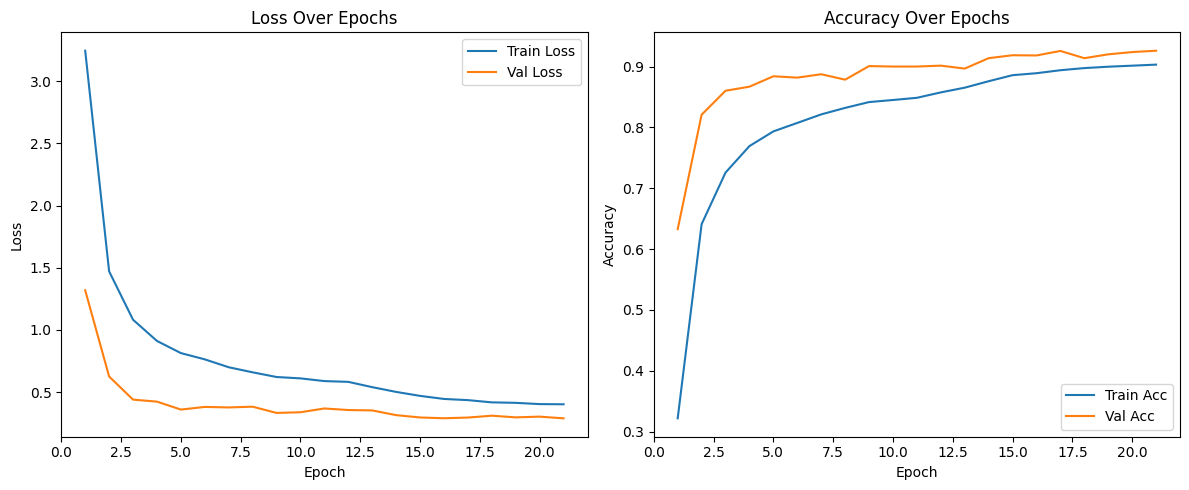


=== Classification Report ===
                                                     precision    recall  f1-score   support

              1000_Lesser Goldfinch Female_juvenile      0.765     0.867     0.812        15
    1001_American Goldfinch Female_Nonbreeding Male      0.960     1.000     0.980        24
              1002_Evening Grosbeak Female_Juvenile      0.950     1.000     0.974        19
                 1003_House Sparrow Female_Juvenile      0.955     0.875     0.913        24
                    1005_European Starling Juvenile      0.867     0.867     0.867        15
        1006_Fox Sparrow Thick-billed_Slate-colored      0.600     0.600     0.600         5
1009_Yellow-rumped Warbler Winter_juvenile Audubons      0.667     0.889     0.762        18
        1010_Dark-eyed Junco Red-backed_Gray-headed      1.000     0.867     0.929        15
                          338_California Quail Male      0.960     1.000     0.980        24
                             339_Gambe

In [30]:
# === Save the best model ===
best_model_path = os.path.join(EXPORT_DIR, "best_model.pth")
torch.save(early_stopping.best_model_wts, best_model_path)
model.load_state_dict(early_stopping.best_model_wts)
print(f"[INFO] Best model saved to {best_model_path}")

# === Export to ONNX ===
dummy_input = torch.randn(1, 3, input_size, input_size).to(device)
onnx_path = os.path.join(EXPORT_DIR, "efficientnet_b7.onnx")
torch.onnx.export(
    model, dummy_input, onnx_path,
    input_names=["input"], output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
    opset_version=11
)
print(f"[INFO] ONNX model saved to {onnx_path}")

# === Save class label map ===
label_path = os.path.join(EXPORT_DIR, "class_labels.txt")
with open(label_path, "w") as f:
    for label in train_dataset.classes:
        f.write(f"{label}\n")
print(f"[INFO] Class labels saved to {label_path}")

# === Plot training curves ===
epochs = [e["epoch"] for e in training_history]
train_losses = [e["train_loss"] for e in training_history]
val_losses = [e["val_loss"] for e in training_history]
train_accs = [e["train_acc"] for e in training_history]
val_accs = [e["val_acc"] for e in training_history]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label="Train Acc")
plt.plot(epochs, val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

# === Evaluate on Validation Set ===
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        all_preds.extend(outputs.argmax(1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\n=== Classification Report ===")
print(classification_report(all_labels, all_preds, target_names=val_dataset.classes, digits=3))

overall_acc = accuracy_score(all_labels, all_preds)
print(f"\n[INFO] Overall Validation Accuracy: {overall_acc:.4f}")


### Evaluation/Interpretability

### Deployment